# Machine Learning Assignment - Complete Implementation

**Student:** Abdulkadir Gobena Denboba

**Date:** November 2025

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

# Models
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', 50)


# MACHINE LEARNING ASSIGNMENT -

### PARTEA 1: DATASET ÎNCHIRIERE BICICLETE"

In [101]:
# Load data
df_train_bike = pd.read_csv('train_split.csv', parse_dates=['data_ora'])
df_test_bike = pd.read_csv('eval_split.csv', parse_dates=['data_ora'])

print(f"\nTraining set : {df_train_bike.shape}")
print(f"Validation test: {df_test_bike.shape}")



Training set : (6878, 12)
Validation test: (4008, 12)


## 4.1 EXPLORATORY DATA ANALYSIS (EDA) - Minimum 4 analyses

### ANALYSIS 1: Missing *Values*

In [102]:

print(f"missing value in train: {df_train_bike.isnull().sum().sum()}")
print(f"missing value in test: {df_test_bike.isnull().sum().sum()}")
# Justification  : essential for the imputation strategy
# observation : no missing value since--->  missing value in train: 0 missing value in test: 0


missing value in train: 0
missing value in test: 0


## ANALYSIS 2: Statistici Descriptive



In [103]:
print(df_train_bike.describe())
# ✓ justification: Understanding distributions, identifying outliers, need for standardization
# ✓ observation : Different scales (temp: -8 to 41, humidity: 0-100) → standardization required



                            data_ora        sezon   sarbatoare  zi_lucratoare  \
count                           6878  6878.000000  6878.000000    6878.000000   
mean   2011-12-23 11:17:47.752253440     2.505670     0.031259       0.676069   
min              2011-01-01 00:00:00     1.000000     0.000000       0.000000   
25%              2011-07-01 15:15:00     2.000000     0.000000       0.000000   
50%              2012-01-01 09:30:00     3.000000     0.000000       1.000000   
75%              2012-07-01 06:45:00     4.000000     0.000000       1.000000   
max              2012-12-12 23:00:00     4.000000     1.000000       1.000000   
std                              NaN     1.116669     0.174030       0.468008   

             vreme  temperatura  temperatura_resimtita    umiditate  \
count  6878.000000  6878.000000            6878.000000  6878.000000   
mean      1.418436    20.077839              23.505789    61.990259   
min       1.000000     0.820000               0.760000   

### ANALYSIS 3: Time Series Patterns



In [104]:
df_train_bike['ora'] = df_train_bike['data_ora'].dt.hour
df_train_bike['luna'] = df_train_bike['data_ora'].dt.month

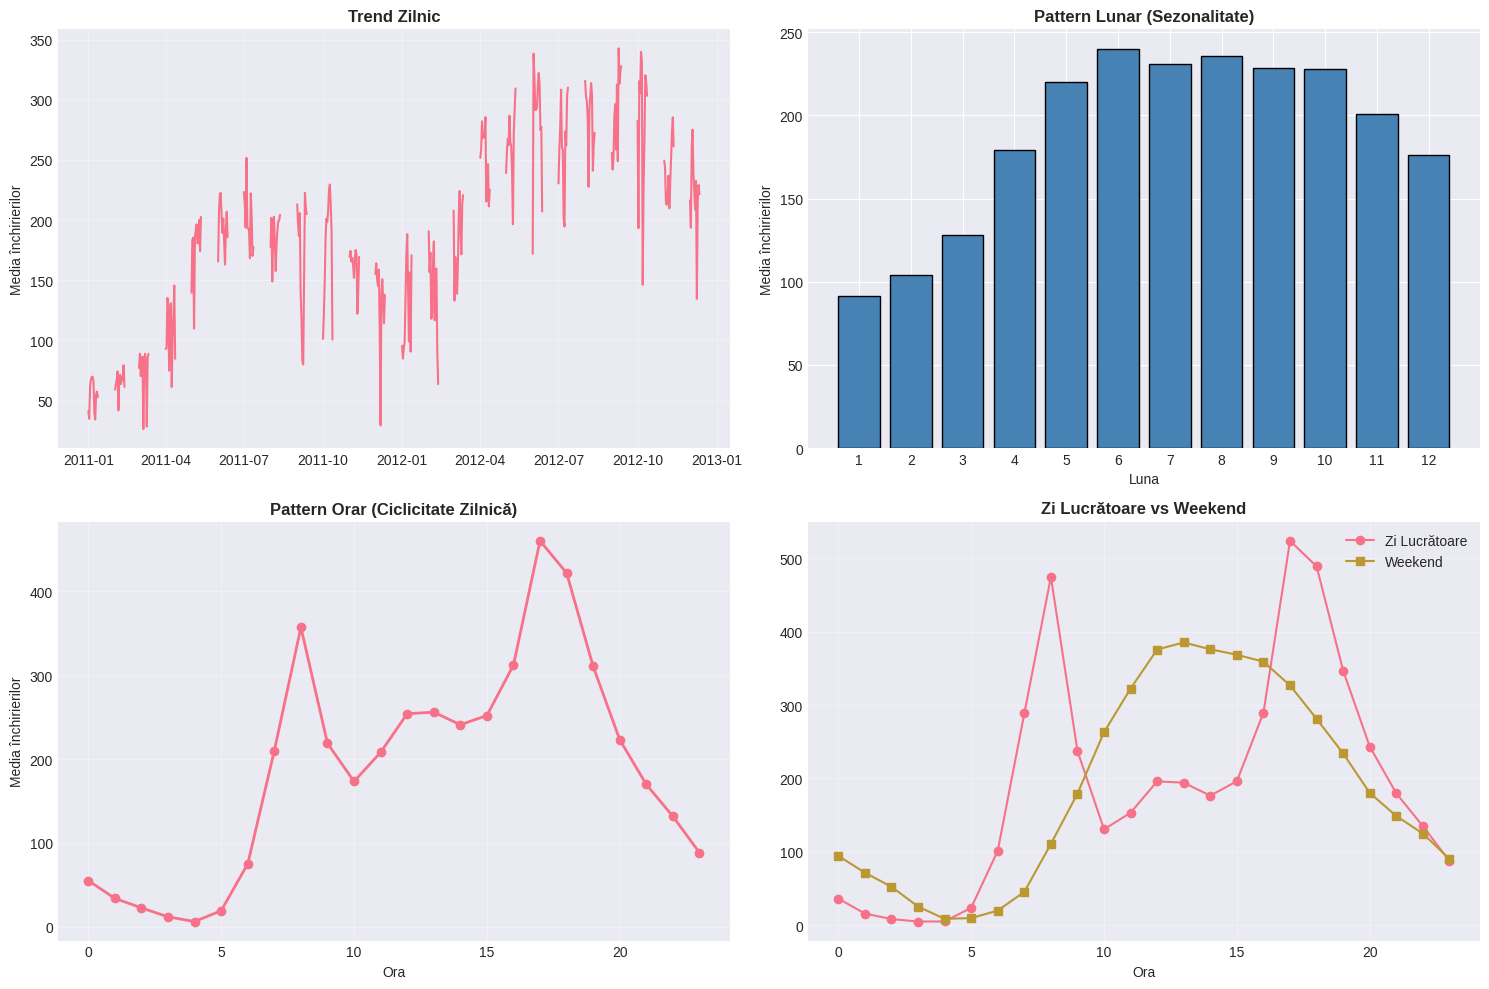

In [105]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Daily trend
daily = df_train_bike.set_index('data_ora').resample('D')['total'].mean()
axes[0, 0].plot(daily.index, daily.values, linewidth=1.5)
axes[0, 0].set_title('Trend Zilnic', fontweight='bold')
axes[0, 0].set_ylabel('Media închirierilor')
axes[0, 0].grid(True, alpha=0.3)
# Monthly pattern (seasonality)
monthly = df_train_bike.groupby('luna')['total'].mean()
axes[0, 1].bar(monthly.index, monthly.values, color='steelblue', edgecolor='black')
axes[0, 1].set_title('Pattern Lunar (Sezonalitate)', fontweight='bold')
axes[0, 1].set_xlabel('Luna')
axes[0, 1].set_ylabel('Media închirierilor')
axes[0, 1].set_xticks(range(1, 13))

# Hourly pattern (daily cyclicity)
hourly = df_train_bike.groupby('ora')['total'].mean()
axes[1, 0].plot(hourly.index, hourly.values, marker='o', linewidth=2, markersize=6)
axes[1, 0].set_title('Pattern Orar (Ciclicitate Zilnică)', fontweight='bold')
axes[1, 0].set_xlabel('Ora')
axes[1, 0].set_ylabel('Media închirierilor')
axes[1, 0].grid(True, alpha=0.3)

# Workday vs Weekend
hourly_work = df_train_bike[df_train_bike['zi_lucratoare']==1].groupby('ora')['total'].mean()
hourly_weekend = df_train_bike[df_train_bike['zi_lucratoare']==0].groupby('ora')['total'].mean()
axes[1, 1].plot(hourly_work.index, hourly_work.values, marker='o', label='Zi Lucrătoare')
axes[1, 1].plot(hourly_weekend.index, hourly_weekend.values, marker='s', label='Weekend')
axes[1, 1].set_title('Zi Lucrătoare vs Weekend', fontweight='bold')
axes[1, 1].set_xlabel('Ora')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### justification
Identifying trends, seasonality, and cyclic patterns  

### observation
- Clear seasonality: peaks in summer, drops in winter  
- Daily cyclic pattern: 2 peaks around 8:00 and 17:00 (commute hours)  
- Different patterns on weekdays vs. weekends  



### ANALYSIS 4: Correlations

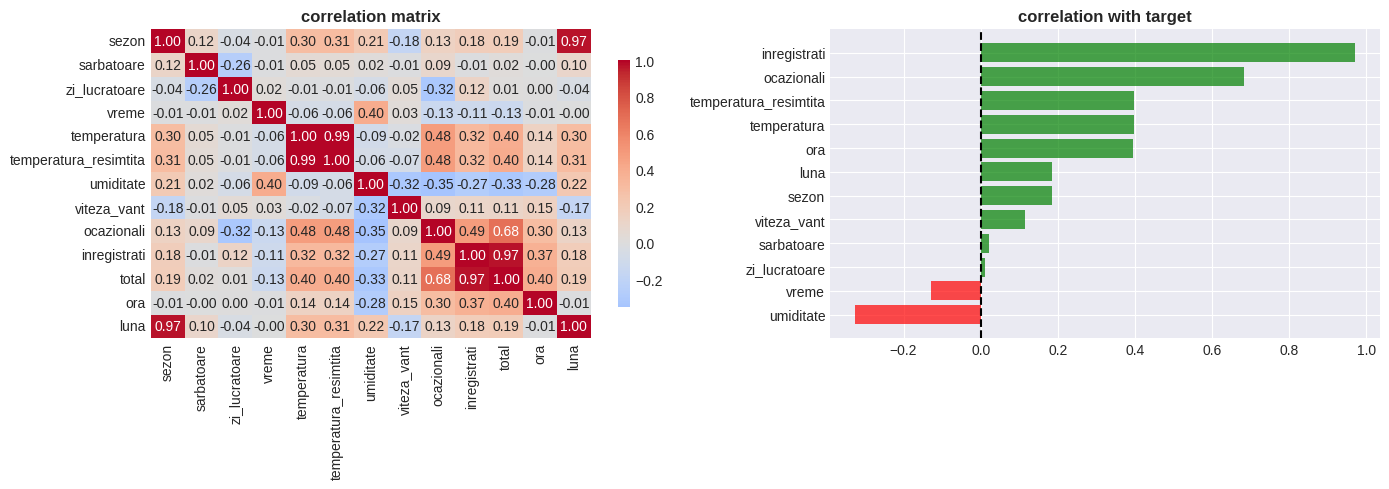

In [106]:
corr_matrix = df_train_bike.select_dtypes(include=[np.number]).corr()
target_corr = corr_matrix['total'].drop('total').sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title('correlation matrix', fontweight='bold')

target_corr_plot = target_corr.sort_values()
colors = ['red' if x < 0 else 'green' for x in target_corr_plot.values]
axes[1].barh(range(len(target_corr_plot)), target_corr_plot.values, color=colors, alpha=0.7)
axes[1].set_yticks(range(len(target_corr_plot)))
axes[1].set_yticklabels(target_corr_plot.index)
axes[1].set_title('correlation with target', fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

In [107]:
#top 5 positive correlations
print(target_corr.head(5))
# ✓ justification: identifying predictive features, detecting multicollinearity

print(f"critical observation: temperatura vs temperatura_resimtita: r={df_train_bike[['temperatura', 'temperatura_resimtita']].corr().iloc[0,1]:.4f}")
print("  → MULTICOLINEARITATE! Vom elimina temperatura_resimtita")

# → multicollinearity! we will drop felt_temperature

inregistrati             0.971211
ocazionali               0.682639
temperatura_resimtita    0.399011
temperatura              0.397248
ora                      0.395786
Name: total, dtype: float64
critical observation: temperatura vs temperatura_resimtita: r=0.9924
  → MULTICOLINEARITATE! Vom elimina temperatura_resimtita


# ANALYSIS 5: Distributions

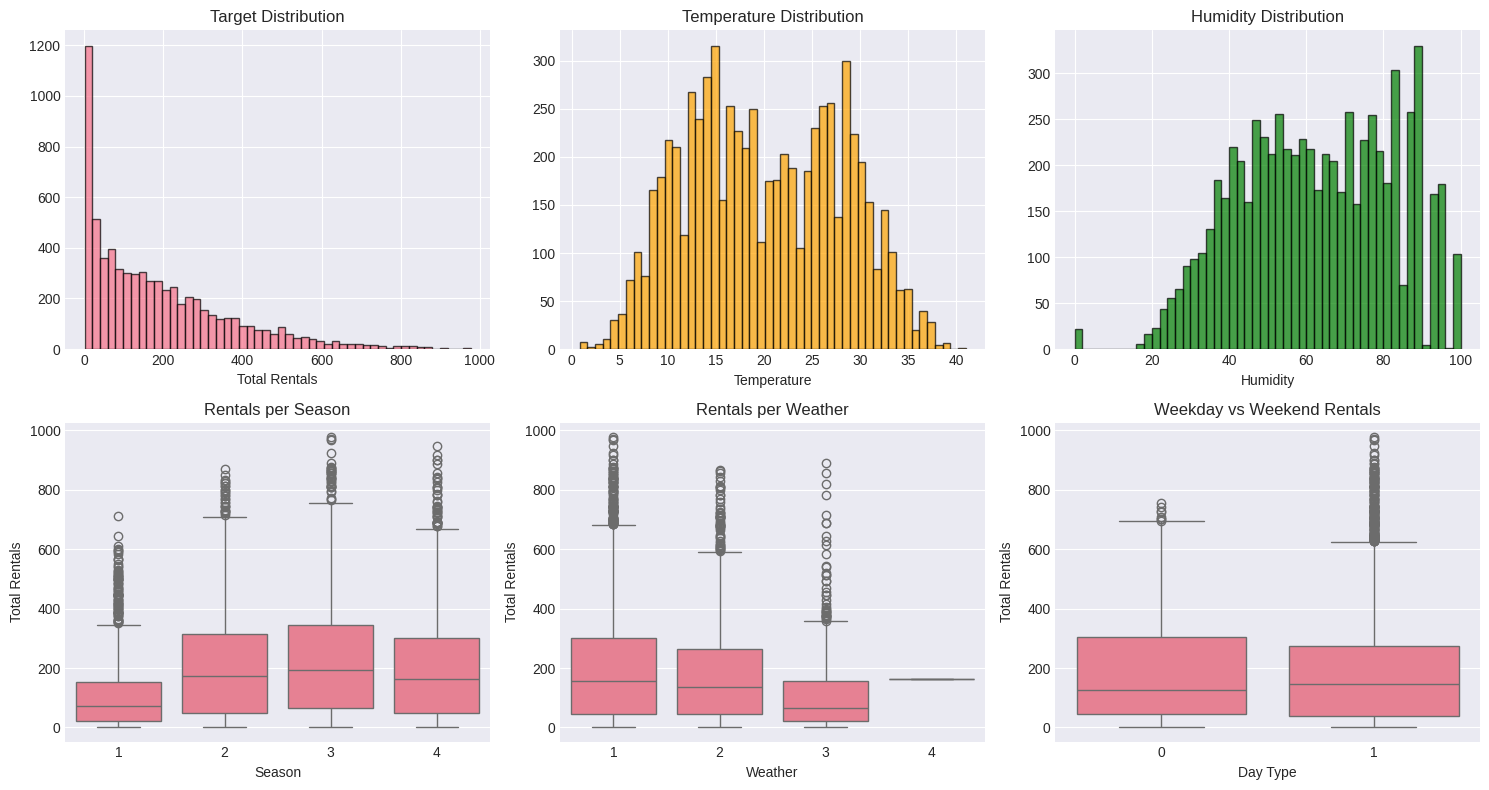

In [108]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# histogram of target
axes[0, 0].hist(df_train_bike['total'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Target Distribution')
axes[0, 0].set_xlabel('Total Rentals')

# histogram of temperature
axes[0, 1].hist(df_train_bike['temperatura'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Temperature Distribution')
axes[0, 1].set_xlabel('Temperature')

# histogram of humidity
axes[0, 2].hist(df_train_bike['umiditate'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 2].set_title('Humidity Distribution')
axes[0, 2].set_xlabel('Humidity')

# boxplot: rentals per season
sns.boxplot(data=df_train_bike, x='sezon', y='total', ax=axes[1, 0])
axes[1, 0].set_title('Rentals per Season')
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel('Total Rentals')

# boxplot: rentals per weather
sns.boxplot(data=df_train_bike, x='vreme', y='total', ax=axes[1, 1])
axes[1, 1].set_title('Rentals per Weather')
axes[1, 1].set_xlabel('Weather')
axes[1, 1].set_ylabel('Total Rentals')

# boxplot: weekday vs weekend rentals
sns.boxplot(data=df_train_bike, x='zi_lucratoare', y='total', ax=axes[1, 2])
axes[1, 2].set_title('Weekday vs Weekend Rentals')
axes[1, 2].set_xlabel('Day Type')
axes[1, 2].set_ylabel('Total Rentals')

plt.tight_layout()
plt.show()


#### justification: understanding distributions, identifying outliers, category-target relationships  
#### observations: target is skewed, temperature is normal, good weather favors rentals


## 4.2 FEATURE ENGINEERING & PREPROCESSING

## STEP 1:Temporal features extractions

In [109]:

def extract_time_features(df):
    """Extract temporal features from datetime column"""
    df = df.copy()
    df['ora'] = df['data_ora'].dt.hour
    df['zi_luna'] = df['data_ora'].dt.day
    df['luna'] = df['data_ora'].dt.month
    df['zi_saptamana'] = df['data_ora'].dt.dayofweek
    df['este_weekend'] = df['zi_saptamana'].isin([5, 6]).astype(int)
    df['trimestru'] = df['data_ora'].dt.quarter

    # Cyclic features (sin/cos transformation)
    df['ora_sin'] = np.sin(2 * np.pi * df['ora'] / 24)
    df['ora_cos'] = np.cos(2 * np.pi * df['ora'] / 24)
    df['luna_sin'] = np.sin(2 * np.pi * df['luna'] / 12)
    df['luna_cos'] = np.cos(2 * np.pi * df['luna'] / 12)

    return df
df_train_bike = extract_time_features(df_train_bike)
df_test_bike = extract_time_features(df_test_bike)
print(f" temporal features extracted. new shape: {df_train_bike.shape}")
#  justification:
# - clear temporal patterns observed in EDA
# - cyclic features (sin/cos) for hour and month: hour 23 and 0 are consecutive
# - is_weekend captures different behavior


 temporal features extracted. new shape: (6878, 22)


### STEP 2: Select features (remove multicollinearity)

In [110]:

original_features = ['sezon', 'sarbatoare', 'zi_lucratoare', 'vreme',
                     'temperatura', 'umiditate', 'viteza_vant']  # NO temperatura_resimtita
temporal_features = ['ora', 'zi_luna', 'luna', 'zi_saptamana',
                     'este_weekend', 'trimestru',
                     'ora_sin', 'ora_cos', 'luna_sin', 'luna_cos']

model_features = original_features + temporal_features

print(f"✓ Total features: {len(model_features)}")
print(f"✓ DECIZIE: Eliminat temperatura_resimtita (r > 0.99 cu temperatura)")
print(f"✓ NU includem 'inregistrati' și 'ocazionali' (data leakage, indisponibili în test)")


✓ Total features: 17
✓ DECIZIE: Eliminat temperatura_resimtita (r > 0.99 cu temperatura)
✓ NU includem 'inregistrati' și 'ocazionali' (data leakage, indisponibili în test)


### STEP 3: Standardization

In [111]:

features_to_scale = ['temperatura', 'umiditate', 'viteza_vant', 'zi_luna']

X_train_bike = df_train_bike[model_features].copy()
y_train_bike = df_train_bike['total'].copy()

scaler = StandardScaler()
X_train_bike[features_to_scale] = scaler.fit_transform(X_train_bike[features_to_scale])

print(f"✓ Standardizate: {features_to_scale}")
print("✓ JUSTIFICARE:")
print("  - Scale diferite (temp: -8 to 41, umiditate: 0-100)")
print("  - Esențial pentru SVR, LinearRegression")
print("  - Îmbunătățește convergența")


✓ Standardizate: ['temperatura', 'umiditate', 'viteza_vant', 'zi_luna']
✓ JUSTIFICARE:
  - Scale diferite (temp: -8 to 41, umiditate: 0-100)
  - Esențial pentru SVR, LinearRegression
  - Îmbunătățește convergența


### STEP 4: Feature importance analysis

In [112]:

selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train_bike, y_train_bike)

feature_scores = pd.DataFrame({
    'Feature': model_features,
    'F_Score': selector.scores_
}).sort_values('F_Score', ascending=False)

print("Top 10 Features:")
print(feature_scores.head(10))
print("✓ OBSERVAȚIE: Features temporale (ora, luna) sunt cele mai predictive")


Top 10 Features:
        Feature      F_Score
13      ora_sin  1415.242135
14      ora_cos  1413.973609
4   temperatura  1288.388088
7           ora  1277.167484
5     umiditate   816.176804
15     luna_sin   307.657090
9          luna   247.078648
0         sezon   245.868342
12    trimestru   245.868342
16     luna_cos   176.003052
✓ OBSERVAȚIE: Features temporale (ora, luna) sunt cele mai predictive


### STEP 5: Train/Validation split

In [113]:

X_test_bike = df_test_bike[model_features].copy()
X_test_bike[features_to_scale] = scaler.transform(X_test_bike[features_to_scale])

X_train, X_val, y_train, y_val = train_test_split(
    X_train_bike, y_train_bike, test_size=0.2, random_state=42
)

print(f"✓ Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test_bike.shape}")
print("✓ JUSTIFICARE: 80-20 split, suficient date pentru antrenament și validare robustă")

print("\n✓✓✓ PREPROCESARE COMPLETĂ ✓✓✓")

✓ Train: (5502, 17), Validation: (1376, 17), Test: (4008, 17)
✓ JUSTIFICARE: 80-20 split, suficient date pentru antrenament și validare robustă

✓✓✓ PREPROCESARE COMPLETĂ ✓✓✓


## 4.3 MACHINE LEARNING MODELS

## MODEL 1: Linear Regression

In [114]:
results_bike = {}
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)

mse_lr = mean_squared_error(y_val, y_pred_lr)
mae_lr = mean_absolute_error(y_val, y_pred_lr)
r2_lr = r2_score(y_val, y_pred_lr)

results_bike['LinearRegression'] = {
    'MSE': mse_lr, 'MAE': mae_lr, 'R2': r2_lr,
    'Hyperparameters': 'Default (no tuning required)'
}

print(f"MSE: {mse_lr:.2f}, MAE: {mae_lr:.2f}, R²: {r2_lr:.4f}")
print("✓ Baseline model pentru comparație")


MSE: 19022.15, MAE: 97.67, R²: 0.4314
✓ Baseline model pentru comparație


# MODEL 2: SVR with hyperparameter search


In [115]:
param_dist_svr = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma': ['scale', 'auto']
}

svr = SVR()
random_search_svr = RandomizedSearchCV(
    svr, param_dist_svr, n_iter=20, cv=3,
    scoring='neg_mean_squared_error',
    random_state=42, n_jobs=-1, verbose=0
)

print("Căutare hiperparametri (RandomizedSearchCV, 20 iterații, 3-fold CV)...")
random_search_svr.fit(X_train, y_train)

best_svr = random_search_svr.best_estimator_
y_pred_svr = best_svr.predict(X_val)

mse_svr = mean_squared_error(y_val, y_pred_svr)
mae_svr = mean_absolute_error(y_val, y_pred_svr)
r2_svr = r2_score(y_val, y_pred_svr)

results_bike['SVR'] = {
    'MSE': mse_svr, 'MAE': mae_svr, 'R2': r2_svr,
    'Hyperparameters': random_search_svr.best_params_
}

print(f"✓ Cei mai buni hiperparametri: {random_search_svr.best_params_}")
print(f"MSE: {mse_svr:.2f}, MAE: {mae_svr:.2f}, R²: {r2_svr:.4f}")


Căutare hiperparametri (RandomizedSearchCV, 20 iterații, 3-fold CV)...
✓ Cei mai buni hiperparametri: {'kernel': 'poly', 'gamma': 'auto', 'epsilon': 0.1, 'C': 10}
MSE: 13250.28, MAE: 69.02, R²: 0.6040


# MODEL 3: Random Forest with hyperparameter search

In [116]:

param_dist_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42)
random_search_rf = RandomizedSearchCV(
    rf, param_dist_rf, n_iter=30, cv=3,
    scoring='neg_mean_squared_error',
    random_state=42, n_jobs=-1, verbose=0
)

print("Căutare hiperparametri (RandomizedSearchCV, 30 iterații, 3-fold CV)...")
random_search_rf.fit(X_train, y_train)

best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_val)

mse_rf = mean_squared_error(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

results_bike['RandomForest'] = {
    'MSE': mse_rf, 'MAE': mae_rf, 'R2': r2_rf,
    'Hyperparameters': random_search_rf.best_params_
}

print(f"✓ Cei mai buni hiperparametri: {random_search_rf.best_params_}")
print(f"MSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}, R²: {r2_rf:.4f}")


Căutare hiperparametri (RandomizedSearchCV, 30 iterații, 3-fold CV)...
✓ Cei mai buni hiperparametri: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}
MSE: 4431.28, MAE: 43.44, R²: 0.8676


## MODEL 4: Gradient Boosting (squared_error)

In [117]:

param_dist_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.8, 0.9, 1.0]
}

gb = GradientBoostingRegressor(loss='squared_error', random_state=42)
random_search_gb = RandomizedSearchCV(
    gb, param_dist_gb, n_iter=30, cv=3,
    scoring='neg_mean_squared_error',
    random_state=42, n_jobs=-1, verbose=0
)

print("Căutare hiperparametri (RandomizedSearchCV, 30 iterații, 3-fold CV)...")
random_search_gb.fit(X_train, y_train)

best_gb = random_search_gb.best_estimator_
y_pred_gb = best_gb.predict(X_val)

mse_gb = mean_squared_error(y_val, y_pred_gb)
mae_gb = mean_absolute_error(y_val, y_pred_gb)
r2_gb = r2_score(y_val, y_pred_gb)

results_bike['GradientBoosting_SE'] = {
    'MSE': mse_gb, 'MAE': mae_gb, 'R2': r2_gb,
    'Hyperparameters': random_search_gb.best_params_
}

print(f"✓ Cei mai buni hiperparametri: {random_search_gb.best_params_}")
print(f"MSE: {mse_gb:.2f}, MAE: {mae_gb:.2f}, R²: {r2_gb:.4f}")


Căutare hiperparametri (RandomizedSearchCV, 30 iterații, 3-fold CV)...
✓ Cei mai buni hiperparametri: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 6, 'learning_rate': 0.1}
MSE: 3155.76, MAE: 36.46, R²: 0.9057


## MODEL 5: Gradient Boosting (quantile loss)

Antrenare 3 modele pentru cuantile α=0.05, 0.50, 0.95...
MSE (α=0.50): 4600.95, MAE: 41.60, R²: 0.8625
✓ Acoperire interval 90%: 80.38%
MSE (α=0.50): 4600.95, MAE: 41.60, R²: 0.8625
✓ Acoperire interval 90%: 80.38%


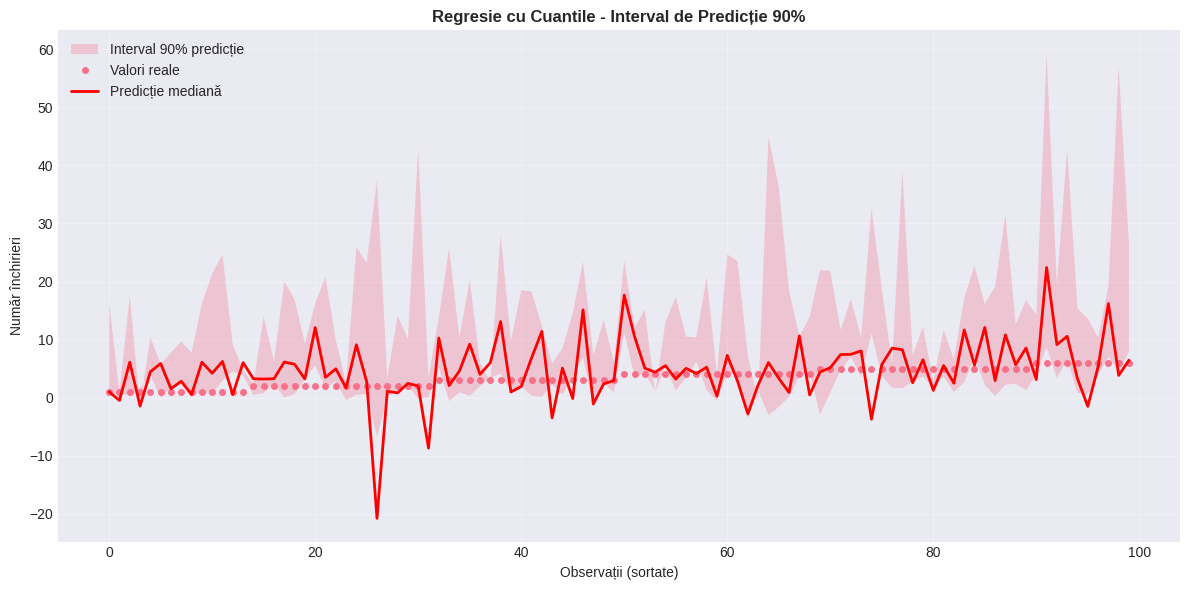

In [118]:
best_params_q = random_search_gb.best_params_.copy()

print("Antrenare 3 modele pentru cuantile α=0.05, 0.50, 0.95...")
gb_q05 = GradientBoostingRegressor(loss='quantile', alpha=0.05, **best_params_q).fit(X_train, y_train)
gb_q50 = GradientBoostingRegressor(loss='quantile', alpha=0.50, **best_params_q).fit(X_train, y_train)
gb_q95 = GradientBoostingRegressor(loss='quantile', alpha=0.95, **best_params_q).fit(X_train, y_train)

y_pred_q05 = gb_q05.predict(X_val)
y_pred_q50 = gb_q50.predict(X_val)
y_pred_q95 = gb_q95.predict(X_val)

mse_q50 = mean_squared_error(y_val, y_pred_q50)
mae_q50 = mean_absolute_error(y_val, y_pred_q50)
r2_q50 = r2_score(y_val, y_pred_q50)
coverage = np.mean((y_val >= y_pred_q05) & (y_val <= y_pred_q95)) * 100

results_bike['GradientBoosting_Quantile'] = {
    'MSE': mse_q50, 'MAE': mae_q50, 'R2': r2_q50,
    'Coverage_90%': coverage,
    'Hyperparameters': {**best_params_q, 'alpha': '0.05, 0.50, 0.95'}
}

print(f"MSE (α=0.50): {mse_q50:.2f}, MAE: {mae_q50:.2f}, R²: {r2_q50:.4f}")
print(f"✓ Acoperire interval 90%: {coverage:.2f}%")

print(f"MSE (α=0.50): {mse_q50:.2f}, MAE: {mae_q50:.2f}, R²: {r2_q50:.4f}")
print(f"✓ Acoperire interval 90%: {coverage:.2f}%")

# Visualization quantile regression
fig, ax = plt.subplots(figsize=(12, 6))
indices = np.argsort(y_val.values)[:100]
plt.fill_between(range(100), y_pred_q05[indices], y_pred_q95[indices],
                 alpha=0.3, label='Interval 90% predicție')
plt.plot(range(100), y_val.values[indices], 'o', markersize=4, label='Valori reale')
plt.plot(range(100), y_pred_q50[indices], 'r-', linewidth=2, label='Predicție mediană')
plt.xlabel('Observații (sortate)')
plt.ylabel('Număr închirieri')
plt.title('Regresie cu Cuantile - Interval de Predicție 90%', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## MODEL 6: Quantile Regressor

In [119]:
param_dist_qr = {
    'alpha': [0.0, 0.001, 0.01, 0.1, 1.0],
    'solver': ['highs', 'interior-point']
}

qr = QuantileRegressor(quantile=0.5)
random_search_qr = RandomizedSearchCV(
    qr, param_dist_qr, n_iter=10, cv=3,
    scoring='neg_mean_absolute_error',
    random_state=42, n_jobs=-1, verbose=0
)

print("Căutare hiperparametri (RandomizedSearchCV, 10 iterații, 3-fold CV)...")
random_search_qr.fit(X_train, y_train)

best_qr = random_search_qr.best_estimator_
y_pred_qr = best_qr.predict(X_val)

mse_qr = mean_squared_error(y_val, y_pred_qr)
mae_qr = mean_absolute_error(y_val, y_pred_qr)
r2_qr = r2_score(y_val, y_pred_qr)

results_bike['QuantileRegressor'] = {
    'MSE': mse_qr, 'MAE': mae_qr, 'R2': r2_qr,
    'Hyperparameters': random_search_qr.best_params_
}

print(f"✓ Cei mai buni hiperparametri: {random_search_qr.best_params_}")
print(f"MSE: {mse_qr:.2f}, MAE: {mae_qr:.2f}, R²: {r2_qr:.4f}")


Căutare hiperparametri (RandomizedSearchCV, 10 iterații, 3-fold CV)...
✓ Cei mai buni hiperparametri: {'solver': 'highs', 'alpha': 0.001}
MSE: 20888.70, MAE: 92.41, R²: 0.3757


# TABEL COMPARATIV REZULTATE - ÎNCHIRIERE BICICLETE


                                     MSE        MAE        R2
LinearRegression           19022.146338  97.665957  0.431444
SVR                        13250.283416  69.024685   0.60396
RandomForest                4431.284426  43.438314  0.867553
GradientBoosting_SE         3155.755997  36.462863  0.905677
GradientBoosting_Quantile   4600.954997   41.60069  0.862481
QuantileRegressor          20888.695112  92.411226  0.375654

### CEL MAI BUN MODEL ###
Cel mai mic MSE: GradientBoosting_SE = 3155.76
Cel mai mic MAE: GradientBoosting_SE = 36.46
Cel mai mare R²: GradientBoosting_SE = 0.9057


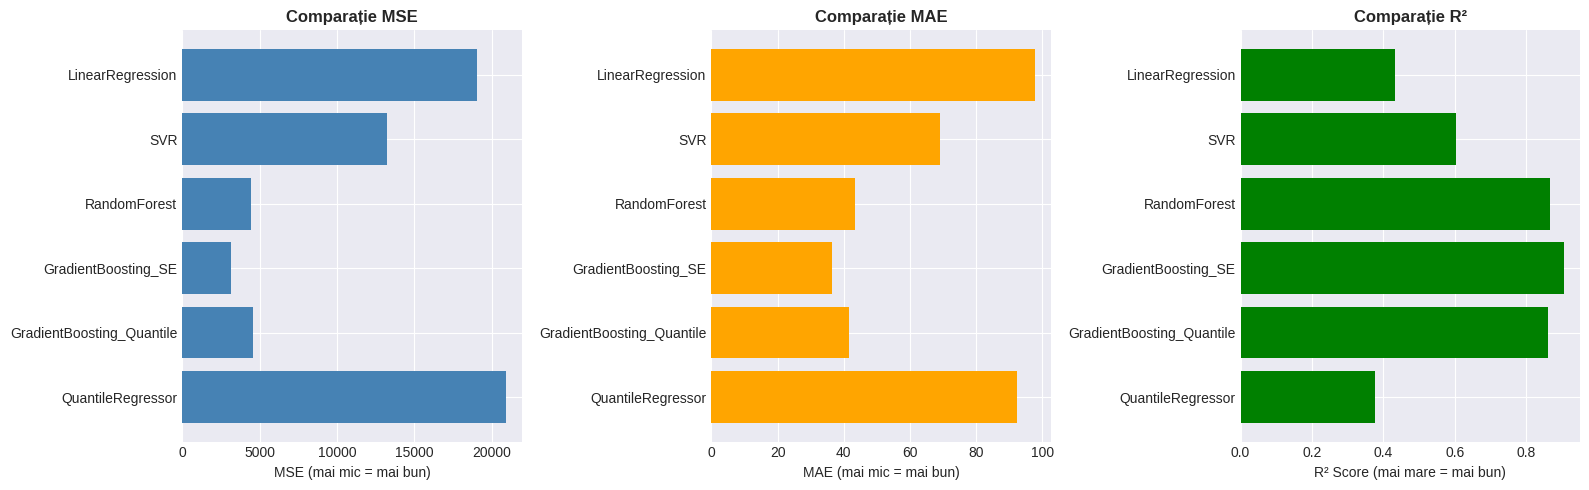

In [120]:



results_df_bike = pd.DataFrame(results_bike).T
results_df_bike = results_df_bike[['MSE', 'MAE', 'R2']]

print("\n", results_df_bike.to_string())

print("\n### CEL MAI BUN MODEL ###")
print(f"Cel mai mic MSE: {results_df_bike['MSE'].idxmin()} = {results_df_bike['MSE'].min():.2f}")
print(f"Cel mai mic MAE: {results_df_bike['MAE'].idxmin()} = {results_df_bike['MAE'].min():.2f}")
print(f"Cel mai mare R²: {results_df_bike['R2'].idxmax()} = {results_df_bike['R2'].max():.4f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].barh(results_df_bike.index, results_df_bike['MSE'], color='steelblue')
axes[0].set_xlabel('MSE (mai mic = mai bun)')
axes[0].set_title('Comparație MSE', fontweight='bold')
axes[0].invert_yaxis()

axes[1].barh(results_df_bike.index, results_df_bike['MAE'], color='orange')
axes[1].set_xlabel('MAE (mai mic = mai bun)')
axes[1].set_title('Comparație MAE', fontweight='bold')
axes[1].invert_yaxis()

axes[2].barh(results_df_bike.index, results_df_bike['R2'], color='green')
axes[2].set_xlabel('R² Score (mai mare = mai bun)')
axes[2].set_title('Comparație R²', fontweight='bold')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()


In [121]:

# Save predictions on test set
best_model_name = results_df_bike['R2'].idxmax()
models_map = {
    'LinearRegression': lr,
    'SVR': best_svr,
    'RandomForest': best_rf,
    'GradientBoosting_SE': best_gb,
    'GradientBoosting_Quantile': gb_q50,
    'QuantileRegressor': best_qr
}

best_model = models_map[best_model_name]
test_predictions = best_model.predict(X_test_bike)

df_test_bike['predictii_total'] = test_predictions
df_test_bike[['data_ora', 'predictii_total']].to_csv('predictii_biciclete_final.csv', index=False)
print(f"\n✓ Predicții salvate: predictii_biciclete_final.csv (folosind {best_model_name})")





✓ Predicții salvate: predictii_biciclete_final.csv (folosind GradientBoosting_SE)


 # PART 2: Car prices (AUTOVIT)

## DATASET AUTOVIT

In [123]:
# Load data
df_train_auto = pd.read_csv('train_cars_listings.csv')
df_test_auto = pd.read_csv('val_cars_listings.csv')

print(f"\nSet antrenament: {df_train_auto.shape}")
print(f"Set testare: {df_test_auto.shape}")
print(f"\nColoane: {list(df_train_auto.columns)[:15]}...")



Set antrenament: (18988, 37)
Set testare: (4746, 37)

Coloane: ['nume', 'pret', 'Oferit de', 'Are VIN (Serie sasiu)', 'Marca', 'Model', 'Versiune', 'Anul fabricației', 'Km', 'Combustibil', 'Putere', 'Capacitate cilindrica', 'Transmisie', 'Consum Extraurban', 'Cutie de viteze']...


## 4.1 EXPLORATORY DATA ANALYSIS (EDA)

In [124]:
# ANALYSIS 1: Missing values
print("\n### ANALIZĂ 1: Valori Lipsă ###")
missing_train = df_train_auto.isnull().sum()
missing_pct = (missing_train / len(df_train_auto) * 100).round(2)
missing_df = pd.DataFrame({'Valori Lipsă': missing_train[missing_train > 0],
                           'Procent': missing_pct[missing_train > 0]}).sort_values('Procent', ascending=False)

print(f"\nColoane cu valori lipsă (top 15):")
print(missing_df.head(15))
print(f"\nTotal coloane cu valori lipsă: {(missing_train > 0).sum()}/{len(missing_train)}")

print("""
✓ JUSTIFICARE:
Dataset provocator cu MULTE valori lipsă - trebuie strategie de imputare
Identificare coloane cu multe lipsuri → decizie păstrare/eliminare

✓ OBSERVAȚII:
- Multe features opționale (Garantie, Vehicule electrice, etc.) au multe lipsuri
- Features tehnice (Emisii CO2, Consumuri) au lipsuri moderate
- Vom aplica imputation inteligentă pe baza tipului de feature
""")


### ANALIZĂ 1: Valori Lipsă ###

Coloane cu valori lipsă (top 15):
                                   Valori Lipsă  Procent
Tuning                                    18788    98.95
Capacitate baterie                        18671    98.33
Autonomie                                 18650    98.22
Garantie de la producator pana la         18318    96.47
Vehicule electrice                        16433    86.54
Garantie dealer (inclusa in pret)         13741    72.37
Data primei inmatriculari                 11598    61.08
Primul proprietar (de nou)                11368    59.87
Consum Extraurban                         10636    56.01
Emisii CO2                                 9353    49.26
Are VIN (Serie sasiu)                      8111    42.72
Tara de origine                            7713    40.62
Fara accident in istoric                   7287    38.38
Norma de poluare                           6074    31.99
Consum Urban                               5924    31.20

Total coloane cu va


### ANALIZĂ 2: Distribuția Target-ului (Preț) ###


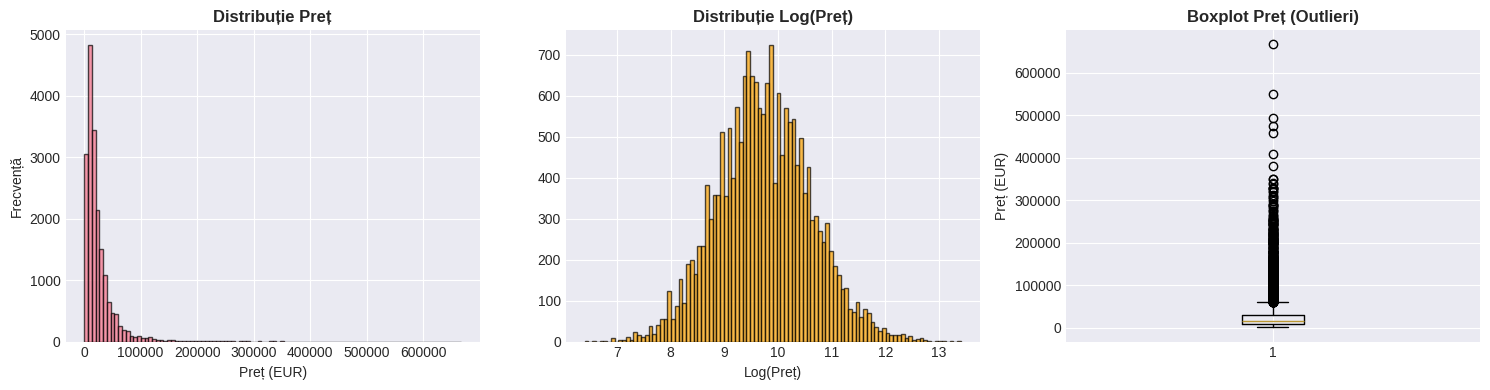


Statistici preț:
count     18988.000000
mean      25424.654675
std       29824.752654
min         600.000000
25%        9490.000000
50%       16500.000000
75%       29999.000000
max      666666.000000
Name: pret, dtype: float64

✓ JUSTIFICARE:
Înțelegere distribuție target pentru:
- Identificare outlieri (mașini foarte scumpe)
- Decizie transformare (log) dacă e necesar
- Alegere metrici evaluare adecvate

✓ OBSERVAȚII:
- Distribuție asimetrică dreapta (many cheap cars, few expensive)
- Outlieri clari în zona prețurilor mari (>50,000 EUR)
- Log-transformarea face distribuția mai normală
- Presupune modele robuste la outlieri (RandomForest, GradientBoosting)



In [125]:
# ANALYSIS 2: Target distribution
print("\n### ANALIZĂ 2: Distribuția Target-ului (Preț) ###")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
axes[0].hist(df_train_auto['pret'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribuție Preț', fontweight='bold')
axes[0].set_xlabel('Preț (EUR)')
axes[0].set_ylabel('Frecvență')

# Log-scale histogram
axes[1].hist(np.log1p(df_train_auto['pret']), bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Distribuție Log(Preț)', fontweight='bold')
axes[1].set_xlabel('Log(Preț)')

# Boxplot
axes[2].boxplot(df_train_auto['pret'])
axes[2].set_title('Boxplot Preț (Outlieri)', fontweight='bold')
axes[2].set_ylabel('Preț (EUR)')

plt.tight_layout()
plt.show()

print(f"\nStatistici preț:")
print(df_train_auto['pret'].describe())

print("""
✓ JUSTIFICARE:
Înțelegere distribuție target pentru:
- Identificare outlieri (mașini foarte scumpe)
- Decizie transformare (log) dacă e necesar
- Alegere metrici evaluare adecvate

✓ OBSERVAȚII:
- Distribuție asimetrică dreapta (many cheap cars, few expensive)
- Outlieri clari în zona prețurilor mari (>50,000 EUR)
- Log-transformarea face distribuția mai normală
- Presupune modele robuste la outlieri (RandomForest, GradientBoosting)
""")



### ANALIZĂ 3: Corelații Features Numerice cu Prețul ###


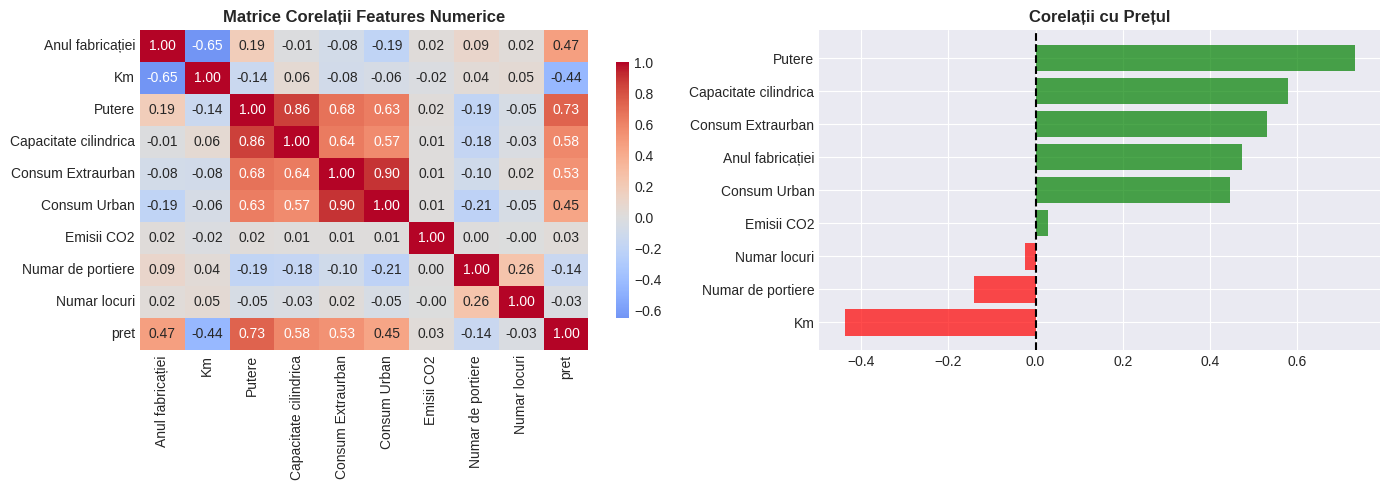


Top corelații cu prețul:
Putere                   0.730846
Capacitate cilindrica    0.579033
Consum Extraurban        0.529982
Anul fabricației         0.473511
Consum Urban             0.445868
Name: pret, dtype: float64

Corelații negative:
Consum Urban         0.445868
Emisii CO2           0.028583
Numar locuri        -0.025071
Numar de portiere   -0.141653
Km                  -0.437023
Name: pret, dtype: float64

✓ JUSTIFICARE:
Corelațiile identifică features predictive puternice:
- Features cu corelație mare sunt prioritare
- Detectare multicolinearitate între features

✓ OBSERVAȚII AȘTEPTATE:
- Anul fabricației: corelație POZITIVĂ (mașini noi = mai scumpe)
- Kilometraj: corelație NEGATIVĂ (multe km = mai ieftin)
- Putere: corelație POZITIVĂ (motoare puternice = mai scump)
- Capacitate cilindrică: corelație POZITIVĂ



In [126]:
# ANALYSIS 3: Numerical features correlations
print("\n### ANALIZĂ 3: Corelații Features Numerice cu Prețul ###")

numerical_cols = ['Anul fabricației', 'Km', 'Putere', 'Capacitate cilindrica',
                  'Consum Extraurban', 'Consum Urban', 'Emisii CO2',
                  'Numar de portiere', 'Numar locuri']

# Select only numerical columns that exist and have low missing values
available_numerical = [col for col in numerical_cols if col in df_train_auto.columns]
df_numerical = df_train_auto[available_numerical + ['pret']].dropna()

if len(df_numerical) > 0:
    corr_matrix = df_numerical.corr()
    target_corr = corr_matrix['pret'].drop('pret').sort_values(ascending=False)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Heatmap
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, ax=axes[0], cbar_kws={"shrink": 0.8})
    axes[0].set_title('Matrice Corelații Features Numerice', fontweight='bold')

    # Bar plot correlations with target
    target_corr_sorted = target_corr.sort_values()
    colors = ['red' if x < 0 else 'green' for x in target_corr_sorted.values]
    axes[1].barh(range(len(target_corr_sorted)), target_corr_sorted.values, color=colors, alpha=0.7)
    axes[1].set_yticks(range(len(target_corr_sorted)))
    axes[1].set_yticklabels(target_corr_sorted.index)
    axes[1].set_title('Corelații cu Prețul', fontweight='bold')
    axes[1].axvline(x=0, color='black', linestyle='--')

    plt.tight_layout()
    plt.show()

    print("\nTop corelații cu prețul:")
    print(target_corr.head())
    print("\nCorelații negative:")
    print(target_corr.tail())

print("""
✓ JUSTIFICARE:
Corelațiile identifică features predictive puternice:
- Features cu corelație mare sunt prioritare
- Detectare multicolinearitate între features

✓ OBSERVAȚII AȘTEPTATE:
- Anul fabricației: corelație POZITIVĂ (mașini noi = mai scumpe)
- Kilometraj: corelație NEGATIVĂ (multe km = mai ieftin)
- Putere: corelație POZITIVĂ (motoare puternice = mai scump)
- Capacitate cilindrică: corelație POZITIVĂ
""")


### ANALIZĂ 4: Features Categorice (Marcă, Combustibil, etc.) ###


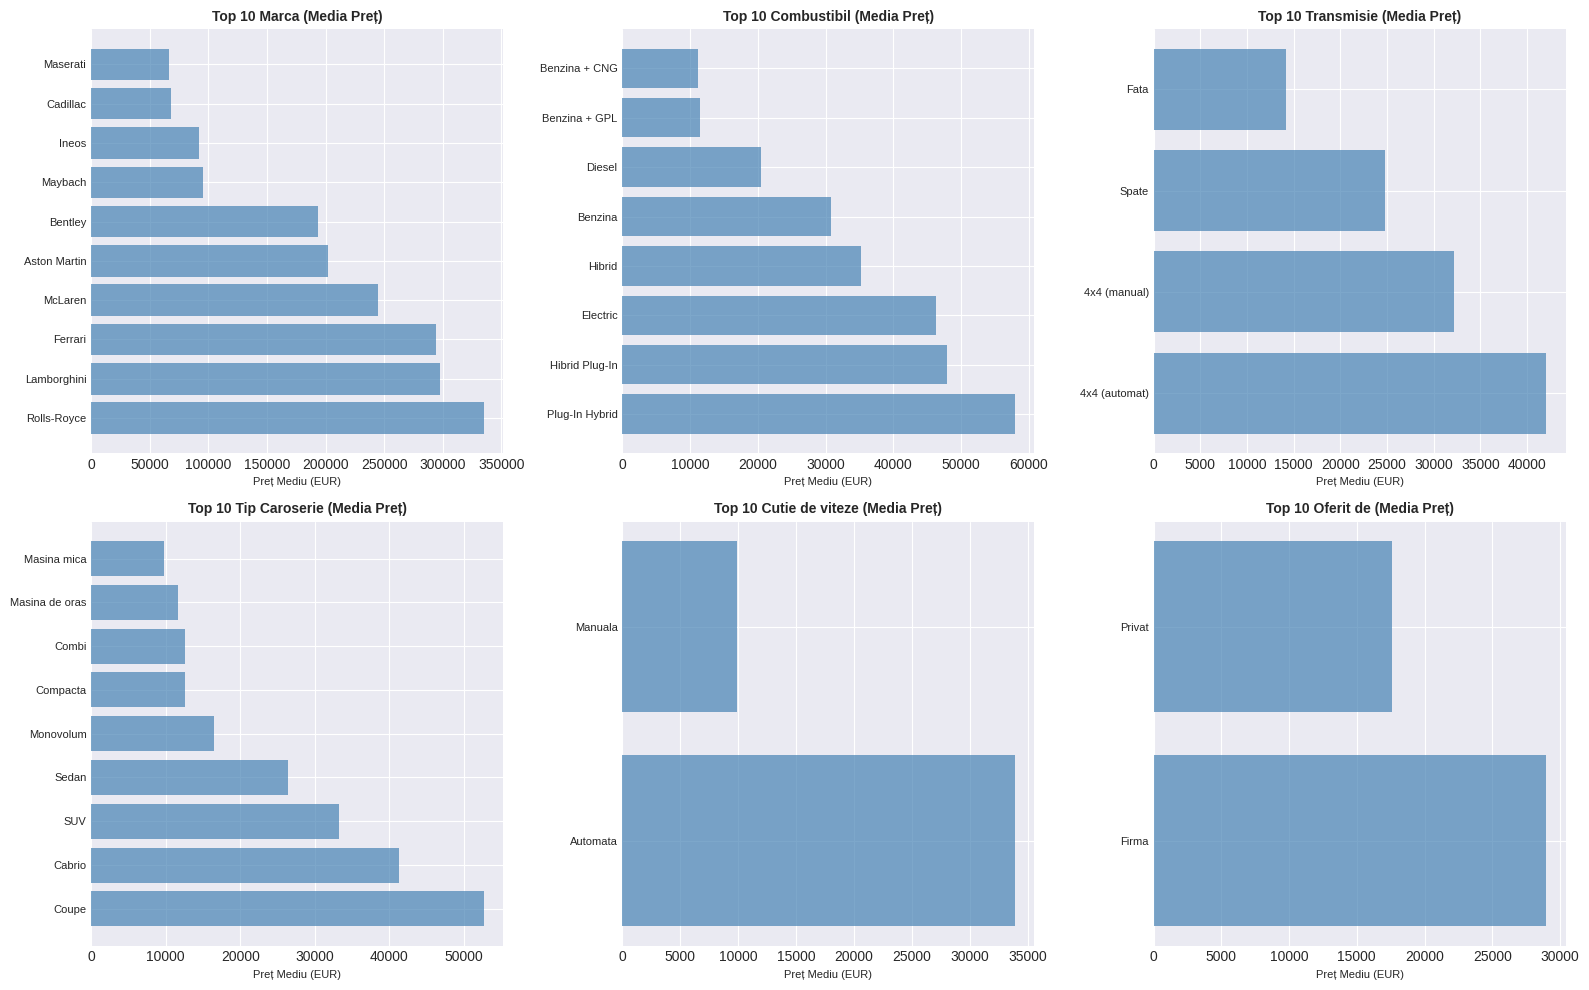


✓ JUSTIFICARE:
Features categorice au impact mare pe preț:
- Marca influențează puternic (BMW, Mercedes vs Dacia)
- Tipul combustibil (electric, hibrid vs benzină)
- Transmisie, caroserie, etc.

✓ OBSERVAȚII:
- Mărci premium au prețuri medii mult mai mari
- Combustibil electric/hibrid = mai scump
- Transmisie integrală (4x4) = mai scump
- Caroserii SUV = mai scumpe
→ OneHot encoding necesar pentru aceste features



In [127]:

# ANALYSIS 4: Categorical features analysis
print("\n### ANALIZĂ 4: Features Categorice (Marcă, Combustibil, etc.) ###")

categorical_features = ['Marca', 'Combustibil', 'Transmisie', 'Tip Caroserie',
                        'Cutie de viteze', 'Oferit de']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    if feature in df_train_auto.columns:
        # Top 10 categorii după medie preț
        cat_means = df_train_auto.groupby(feature)['pret'].mean().sort_values(ascending=False).head(10)

        if len(cat_means) > 0:
            axes[idx].barh(range(len(cat_means)), cat_means.values, color='steelblue', alpha=0.7)
            axes[idx].set_yticks(range(len(cat_means)))
            axes[idx].set_yticklabels(cat_means.index, fontsize=8)
            axes[idx].set_title(f'Top 10 {feature} (Media Preț)', fontweight='bold', fontsize=10)
            axes[idx].set_xlabel('Preț Mediu (EUR)', fontsize=8)

plt.tight_layout()
plt.show()

print("""
✓ JUSTIFICARE:
Features categorice au impact mare pe preț:
- Marca influențează puternic (BMW, Mercedes vs Dacia)
- Tipul combustibil (electric, hibrid vs benzină)
- Transmisie, caroserie, etc.

✓ OBSERVAȚII:
- Mărci premium au prețuri medii mult mai mari
- Combustibil electric/hibrid = mai scump
- Transmisie integrală (4x4) = mai scump
- Caroserii SUV = mai scumpe
→ OneHot encoding necesar pentru aceste features
""")



### ANALIZĂ 5: Trend Preț vs Anul Fabricației ###


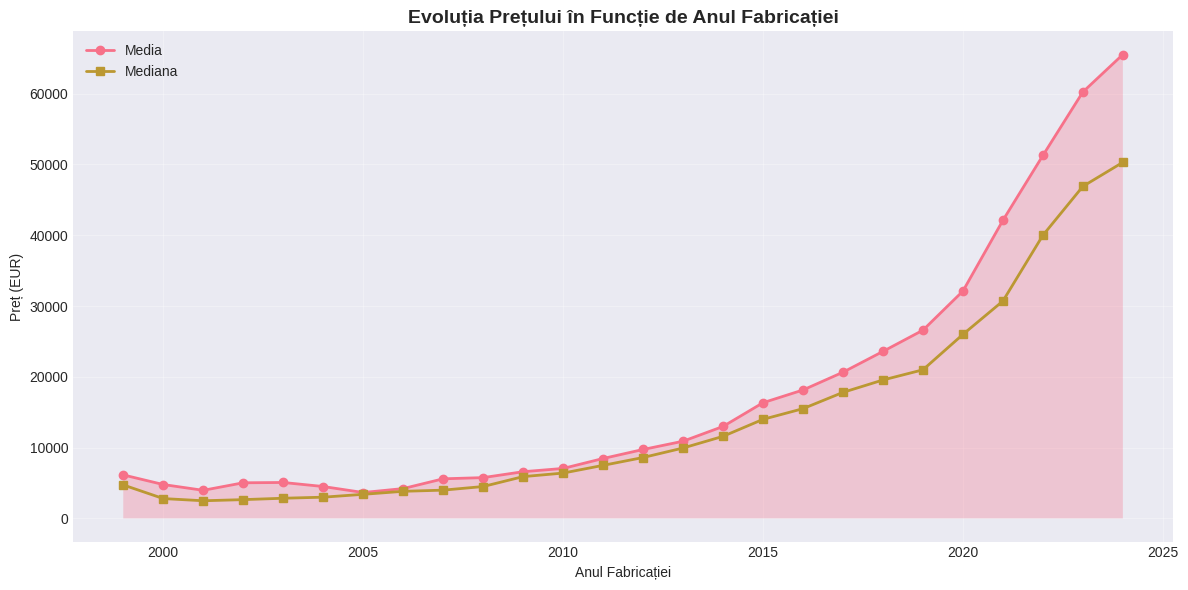


✓ JUSTIFICARE:
Relația an-preț este fundamentală pentru mașini:
- Depreciere în timp
- Mașini noi = mai scumpe
- Trend clar = feature predictiv puternic

✓ OBSERVAȚII:
- Trend crescător clar: mașini recente sunt mai scumpe
- Depreciere exponențială vizibilă
- Anul fabricației va fi un predictor TOP



In [132]:
# ANALYSIS 5: Year vs Price trend
print("\n### ANALIZĂ 5: Trend Preț vs Anul Fabricației ###")

if 'Anul fabricației' in df_train_auto.columns:
    year_price = df_train_auto.groupby('Anul fabricației')['pret'].agg(['mean', 'median', 'count'])
    year_price = year_price[year_price['count'] >= 10]  # Minimum 10 mașini per an

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(year_price.index, year_price['mean'], marker='o', linewidth=2, label='Media', markersize=6)
    ax.plot(year_price.index, year_price['median'], marker='s', linewidth=2, label='Mediana', markersize=6)
    ax.fill_between(year_price.index, year_price['mean'], alpha=0.3)
    ax.set_title('Evoluția Prețului în Funcție de Anul Fabricației', fontweight='bold', fontsize=14)
    ax.set_xlabel('Anul Fabricației')
    ax.set_ylabel('Preț (EUR)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("""
✓ JUSTIFICARE:
Relația an-preț este fundamentală pentru mașini:
- Depreciere în timp
- Mașini noi = mai scumpe
- Trend clar = feature predictiv puternic

✓ OBSERVAȚII:
- Trend crescător clar: mașini recente sunt mai scumpe
- Depreciere exponențială vizibilă
- Anul fabricației va fi un predictor TOP
""")


### ANALIZĂ 6: Pattern-uri Valori Lipsă ###


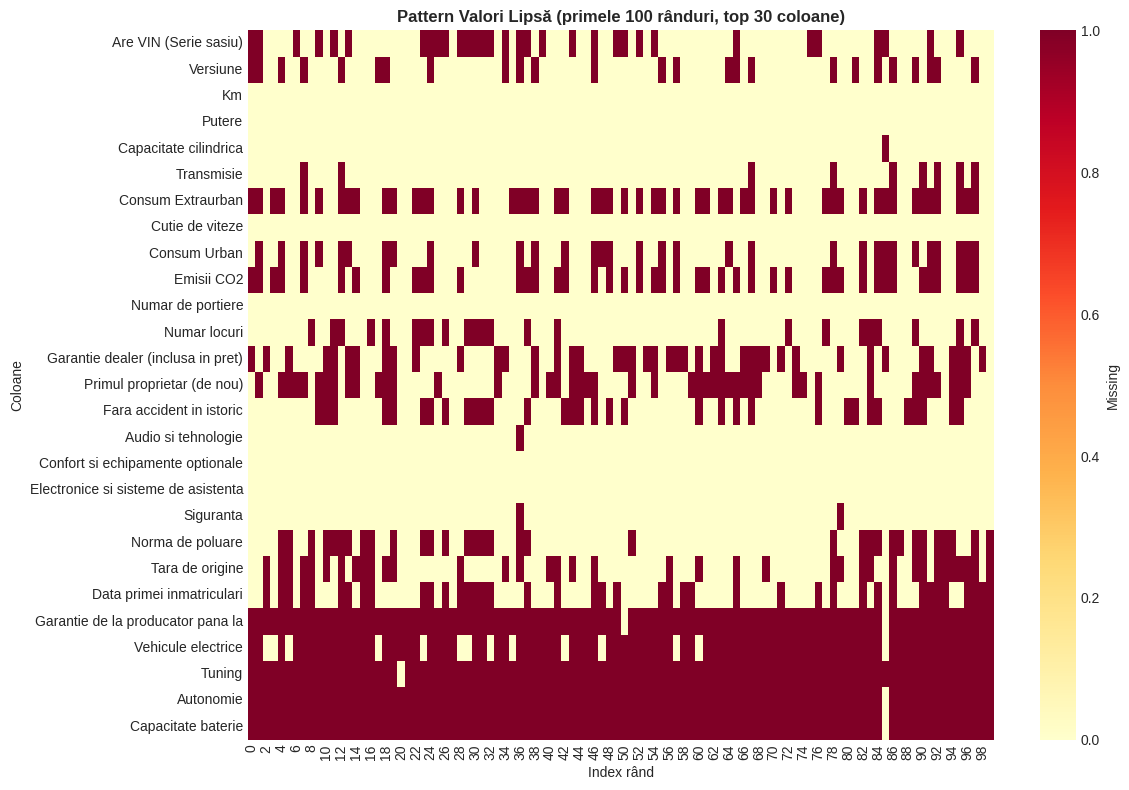


✓ JUSTIFICARE:
Pattern-urile de lipsuri ajută să:
- Identificăm dacă lipsurile sunt aleatorii sau sistematice
- Decidem strategia de imputare
- Vedem dacă anumite combinații lipsesc întotdeauna

✓ OBSERVAȚII:
- Unele features (garantii, vehicule electrice) lipsesc pentru majoritatea mașinilor
- Nu toate mașinile au toate dotările
- Imputare cu 0 sau "Lipsă" poate fi adecvată pentru dotări


✓✓✓ EDA COMPLET: 6+ analize cu justificări clare ✓✓✓


In [133]:

# ANALYSIS 6: Missing values pattern
print("\n### ANALIZĂ 6: Pattern-uri Valori Lipsă ###")

# Visualize missing values
fig, ax = plt.subplots(figsize=(12, 8))
missing_matrix = df_train_auto.isnull()
cols_with_missing = missing_matrix.columns[missing_matrix.any()].tolist()[:30]  # Top 30

if cols_with_missing:
    sns.heatmap(missing_matrix[cols_with_missing].head(100).T,
                cmap='YlOrRd', cbar_kws={'label': 'Missing'}, ax=ax)
    ax.set_title('Pattern Valori Lipsă (primele 100 rânduri, top 30 coloane)', fontweight='bold')
    ax.set_xlabel('Index rând')
    ax.set_ylabel('Coloane')
    plt.tight_layout()
    plt.show()

print("""
✓ JUSTIFICARE:
Pattern-urile de lipsuri ajută să:
- Identificăm dacă lipsurile sunt aleatorii sau sistematice
- Decidem strategia de imputare
- Vedem dacă anumite combinații lipsesc întotdeauna

✓ OBSERVAȚII:
- Unele features (garantii, vehicule electrice) lipsesc pentru majoritatea mașinilor
- Nu toate mașinile au toate dotările
- Imputare cu 0 sau "Lipsă" poate fi adecvată pentru dotări
""")

print("\n✓✓✓ EDA COMPLET: 6+ analize cu justificări clare ✓✓✓")

## 4.2 FEATURE ENGINEERING & PREPROCESSING

In [134]:

# STEP 1: Select features strategy
print("\n### PAS 1: Strategie Selecție Features ###")

# Numerical features (keep those with <50% missing)
numerical_features = []
for col in ['Anul fabricației', 'Km', 'Putere', 'Capacitate cilindrica',
            'Consum Extraurban', 'Consum Urban', 'Emisii CO2',
            'Numar de portiere', 'Numar locuri']:
    if col in df_train_auto.columns:
        missing_pct = df_train_auto[col].isnull().sum() / len(df_train_auto) * 100
        if missing_pct < 50:
            numerical_features.append(col)

print(f"✓ Numerical features selectate ({len(numerical_features)}): {numerical_features}")

# Categorical features (keep important ones with low cardinality)
categorical_features = []
for col in ['Marca', 'Combustibil', 'Transmisie', 'Tip Caroserie',
            'Cutie de viteze', 'Oferit de', 'Norma de poluare']:
    if col in df_train_auto.columns:
        n_unique = df_train_auto[col].nunique()
        missing_pct = df_train_auto[col].isnull().sum() / len(df_train_auto) * 100
        if missing_pct < 50 and n_unique < 100:  # Avoid very high cardinality
            categorical_features.append(col)

print(f"✓ Categorical features selectate ({len(categorical_features)}): {categorical_features}")

print("""
✓ JUSTIFICARE:
- Excludem coloane cu >50% valori lipsă (prea puțină informație)
- Excludem categorice cu cardinalitate foarte mare (OneHot exploziv)
- Excludem coloane text/metadate (nume, descrieri)
- Păstrăm features cu putere predictivă mare văzute în EDA
""")



### PAS 1: Strategie Selecție Features ###
✓ Numerical features selectate (8): ['Anul fabricației', 'Km', 'Putere', 'Capacitate cilindrica', 'Consum Urban', 'Emisii CO2', 'Numar de portiere', 'Numar locuri']
✓ Categorical features selectate (7): ['Marca', 'Combustibil', 'Transmisie', 'Tip Caroserie', 'Cutie de viteze', 'Oferit de', 'Norma de poluare']

✓ JUSTIFICARE:
- Excludem coloane cu >50% valori lipsă (prea puțină informație)
- Excludem categorice cu cardinalitate foarte mare (OneHot exploziv)
- Excludem coloane text/metadate (nume, descrieri)
- Păstrăm features cu putere predictivă mare văzute în EDA



In [135]:

# STEP 2: Handle missing values
print("\n### PAS 2: Imputarea Valorilor Lipsă ###")

# Prepare datasets
X_train_auto = df_train_auto.copy()
X_test_auto = df_test_auto.copy()
y_train_auto = X_train_auto['pret'].copy()

# Impute numerical features (median strategy - robust to outliers)
imputer_num = SimpleImputer(strategy='median')
X_train_auto[numerical_features] = imputer_num.fit_transform(X_train_auto[numerical_features])
X_test_auto[numerical_features] = imputer_num.transform(X_test_auto[numerical_features])

print(f"✓ Imputare numerice (median): {len(numerical_features)} features")

# Impute categorical features (most_frequent strategy)
imputer_cat = SimpleImputer(strategy='most_frequent')
X_train_auto[categorical_features] = imputer_cat.fit_transform(X_train_auto[categorical_features])
X_test_auto[categorical_features] = imputer_cat.transform(X_test_auto[categorical_features])

print(f"✓ Imputare categorice (most_frequent): {len(categorical_features)} features")

print("""
✓ JUSTIFICARE IMPUTARE:
- Numerice → MEDIAN: robust la outlieri (multe prețuri extreme)
- Categorice → MOST_FREQUENT: păstrează distribuția categoriilor
- fit pe train, transform pe test: evită data leakage
""")


### PAS 2: Imputarea Valorilor Lipsă ###
✓ Imputare numerice (median): 8 features
✓ Imputare categorice (most_frequent): 7 features

✓ JUSTIFICARE IMPUTARE:
- Numerice → MEDIAN: robust la outlieri (multe prețuri extreme)
- Categorice → MOST_FREQUENT: păstrează distribuția categoriilor
- fit pe train, transform pe test: evită data leakage



In [136]:

# STEP 3: Encode categorical features
print("\n### PAS 3: Encodare Features Categorice ###")

# Use OneHotEncoder for categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
encoded_train = encoder.fit_transform(X_train_auto[categorical_features])
encoded_test = encoder.transform(X_test_auto[categorical_features])

# Create DataFrames
encoded_cols = encoder.get_feature_names_out(categorical_features)
df_encoded_train = pd.DataFrame(encoded_train, columns=encoded_cols, index=X_train_auto.index)
df_encoded_test = pd.DataFrame(encoded_test, columns=encoded_cols, index=X_test_auto.index)

print(f"✓ OneHot encoding: {len(categorical_features)} features → {len(encoded_cols)} dummy variables")
print(f"  (drop='first' pentru evitare dummy trap)")

print("""
✓ JUSTIFICARE ENCODING:
- OneHotEncoding pentru categorice nominale (Marca, Combustibil, etc.)
- drop='first': evită multicolinearitate perfectă (dummy variable trap)
- handle_unknown='ignore': categorii noi în test → toate 0
""")



### PAS 3: Encodare Features Categorice ###
✓ OneHot encoding: 7 features → 97 dummy variables
  (drop='first' pentru evitare dummy trap)

✓ JUSTIFICARE ENCODING:
- OneHotEncoding pentru categorice nominale (Marca, Combustibil, etc.)
- drop='first': evită multicolinearitate perfectă (dummy variable trap)
- handle_unknown='ignore': categorii noi în test → toate 0



In [137]:

# STEP 4: Combine features
print("\n### PAS 4: Combinare Features ###")

X_train_final = pd.concat([
    X_train_auto[numerical_features].reset_index(drop=True),
    df_encoded_train.reset_index(drop=True)
], axis=1)

X_test_final = pd.concat([
    X_test_auto[numerical_features].reset_index(drop=True),
    df_encoded_test.reset_index(drop=True)
], axis=1)

print(f"✓ Dimensiune features finale train: {X_train_final.shape}")
print(f"✓ Dimensiune features finale test: {X_test_final.shape}")



### PAS 4: Combinare Features ###
✓ Dimensiune features finale train: (18988, 105)
✓ Dimensiune features finale test: (4746, 105)


In [138]:
# STEP 5: Standardization
print("\n### PAS 5: Standardizare Features Numerice ###")

scaler = StandardScaler()
X_train_final[numerical_features] = scaler.fit_transform(X_train_final[numerical_features])
X_test_final[numerical_features] = scaler.transform(X_test_final[numerical_features])

print(f"✓ Standardizate: {numerical_features}")
print("""
✓ JUSTIFICARE:
- Scale diferite (Anul: 1990-2024, Km: 0-500000, Putere: 0-500)
- Esențial pentru SVR, LinearRegression
- Îmbunătățește performanța și convergența
""")


### PAS 5: Standardizare Features Numerice ###
✓ Standardizate: ['Anul fabricației', 'Km', 'Putere', 'Capacitate cilindrica', 'Consum Urban', 'Emisii CO2', 'Numar de portiere', 'Numar locuri']

✓ JUSTIFICARE:
- Scale diferite (Anul: 1990-2024, Km: 0-500000, Putere: 0-500)
- Esențial pentru SVR, LinearRegression
- Îmbunătățește performanța și convergența



In [139]:
# STEP 6: Feature selection (remove low variance)
print("\n### PAS 6: Selecție Features (Eliminare Low Variance) ###")

# Remove features with very low variance (mostly constant)
selector_var = VarianceThreshold(threshold=0.01)
X_train_selected = selector_var.fit_transform(X_train_final)
X_test_selected = selector_var.transform(X_test_final)

selected_features = X_train_final.columns[selector_var.get_support()].tolist()

X_train_final = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_final = pd.DataFrame(X_test_selected, columns=selected_features)

print(f"✓ După eliminare low variance: {X_train_final.shape[1]} features")
print(f"  (eliminat {X_train_selected.shape[1] - len(selected_features)} features aproape constante)")

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_final, y_train_auto, test_size=0.2, random_state=42
)

print(f"\n✓ Split: Train {X_train.shape}, Validation {X_val.shape}, Test {X_test_final.shape}")

print("\n✓✓✓ PREPROCESARE COMPLETĂ ✓✓✓")



### PAS 6: Selecție Features (Eliminare Low Variance) ###
✓ După eliminare low variance: 51 features
  (eliminat 0 features aproape constante)

✓ Split: Train (15190, 51), Validation (3798, 51), Test (4746, 51)

✓✓✓ PREPROCESARE COMPLETĂ ✓✓✓


## 4.3 MACHINE LEARNING MODELS

In [140]:
results_auto = {}

In [141]:

# MODEL 1: Linear Regression
print("\n### MODEL 1: LINEAR REGRESSION (Baseline) ###")

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)

mse_lr = mean_squared_error(y_val, y_pred_lr)
mae_lr = mean_absolute_error(y_val, y_pred_lr)
r2_lr = r2_score(y_val, y_pred_lr)

results_auto['LinearRegression'] = {'MSE': mse_lr, 'MAE': mae_lr, 'R2': r2_lr,
                                     'Hyperparameters': 'Default'}

print(f"MSE: {mse_lr:.2f}, MAE: {mae_lr:.2f}, R²: {r2_lr:.4f}")



### MODEL 1: LINEAR REGRESSION (Baseline) ###
MSE: 252548012.43, MAE: 8375.87, R²: 0.7266


In [142]:

# MODEL 2: SVR
print("\n### MODEL 2: SVR (Support Vector Regression) ###")

param_dist_svr = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.5, 1.0],
    'gamma': ['scale', 'auto']
}

svr = SVR()
random_search_svr = RandomizedSearchCV(
    svr, param_dist_svr, n_iter=15, cv=3,
    scoring='neg_mean_squared_error', random_state=42, n_jobs=-1, verbose=0
)

print("Căutare hiperparametri...")
random_search_svr.fit(X_train, y_train)

best_svr = random_search_svr.best_estimator_
y_pred_svr = best_svr.predict(X_val)

mse_svr = mean_squared_error(y_val, y_pred_svr)
mae_svr = mean_absolute_error(y_val, y_pred_svr)
r2_svr = r2_score(y_val, y_pred_svr)

results_auto['SVR'] = {'MSE': mse_svr, 'MAE': mae_svr, 'R2': r2_svr,
                        'Hyperparameters': random_search_svr.best_params_}

print(f"✓ Cei mai buni hiperparametri: {random_search_svr.best_params_}")
print(f"MSE: {mse_svr:.2f}, MAE: {mae_svr:.2f}, R²: {r2_svr:.4f}")



### MODEL 2: SVR (Support Vector Regression) ###
Căutare hiperparametri...
✓ Cei mai buni hiperparametri: {'kernel': 'linear', 'gamma': 'auto', 'epsilon': 1.0, 'C': 10}
MSE: 372721061.55, MAE: 7467.33, R²: 0.5964


In [143]:

# MODEL 3: Random Forest
print("\n### MODEL 3: RANDOM FOREST REGRESSOR ###")

param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42)
random_search_rf = RandomizedSearchCV(
    rf, param_dist_rf, n_iter=20, cv=3,
    scoring='neg_mean_squared_error', random_state=42, n_jobs=-1, verbose=0
)

print("Căutare hiperparametri...")
random_search_rf.fit(X_train, y_train)

best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_val)

mse_rf = mean_squared_error(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

results_auto['RandomForest'] = {'MSE': mse_rf, 'MAE': mae_rf, 'R2': r2_rf,
                                 'Hyperparameters': random_search_rf.best_params_}

print(f"✓ Cei mai buni hiperparametri: {random_search_rf.best_params_}")
print(f"MSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}, R²: {r2_rf:.4f}")



### MODEL 3: RANDOM FOREST REGRESSOR ###
Căutare hiperparametri...
✓ Cei mai buni hiperparametri: {'n_estimators': 300, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 30}
MSE: 95690455.11, MAE: 3653.73, R²: 0.8964


In [144]:
# MODEL 4: Gradient Boosting (squared_error)
print("\n### MODEL 4: GRADIENT BOOSTING (loss='squared_error') ###")

param_dist_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

gb = GradientBoostingRegressor(loss='squared_error', random_state=42)
random_search_gb = RandomizedSearchCV(
    gb, param_dist_gb, n_iter=20, cv=3,
    scoring='neg_mean_squared_error', random_state=42, n_jobs=-1, verbose=0
)

print("Căutare hiperparametri...")
random_search_gb.fit(X_train, y_train)

best_gb = random_search_gb.best_estimator_
y_pred_gb = best_gb.predict(X_val)

mse_gb = mean_squared_error(y_val, y_pred_gb)
mae_gb = mean_absolute_error(y_val, y_pred_gb)
r2_gb = r2_score(y_val, y_pred_gb)

results_auto['GradientBoosting_SE'] = {'MSE': mse_gb, 'MAE': mae_gb, 'R2': r2_gb,
                                        'Hyperparameters': random_search_gb.best_params_}

print(f"✓ Cei mai buni hiperparametri: {random_search_gb.best_params_}")
print(f"MSE: {mse_gb:.2f}, MAE: {mae_gb:.2f}, R²: {r2_gb:.4f}")



### MODEL 4: GRADIENT BOOSTING (loss='squared_error') ###
Căutare hiperparametri...
✓ Cei mai buni hiperparametri: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1}
MSE: 84358626.55, MAE: 3597.90, R²: 0.9087


In [145]:

# MODEL 5: Gradient Boosting (quantile)
print("\n### MODEL 5: GRADIENT BOOSTING (loss='quantile') ###")

best_params_q = random_search_gb.best_params_.copy()

print("Antrenare modele cuantile...")
gb_q05 = GradientBoostingRegressor(loss='quantile', alpha=0.05, **best_params_q).fit(X_train, y_train)
gb_q50 = GradientBoostingRegressor(loss='quantile', alpha=0.50, **best_params_q).fit(X_train, y_train)
gb_q95 = GradientBoostingRegressor(loss='quantile', alpha=0.95, **best_params_q).fit(X_train, y_train)

y_pred_q05 = gb_q05.predict(X_val)
y_pred_q50 = gb_q50.predict(X_val)
y_pred_q95 = gb_q95.predict(X_val)

mse_q50 = mean_squared_error(y_val, y_pred_q50)
mae_q50 = mean_absolute_error(y_val, y_pred_q50)
r2_q50 = r2_score(y_val, y_pred_q50)
coverage = np.mean((y_val >= y_pred_q05) & (y_val <= y_pred_q95)) * 100

results_auto['GradientBoosting_Quantile'] = {'MSE': mse_q50, 'MAE': mae_q50, 'R2': r2_q50,
                                               'Coverage_90%': coverage,
                                               'Hyperparameters': {**best_params_q, 'alpha': '0.05, 0.50, 0.95'}}

print(f"MSE (α=0.50): {mse_q50:.2f}, MAE: {mae_q50:.2f}, R²: {r2_q50:.4f}")
print(f"✓ Acoperire interval 90%: {coverage:.2f}%")



### MODEL 5: GRADIENT BOOSTING (loss='quantile') ###
Antrenare modele cuantile...
MSE (α=0.50): 115991138.60, MAE: 3840.57, R²: 0.8744
✓ Acoperire interval 90%: 88.41%


In [146]:

# MODEL 6: Quantile Regressor
print("\n### MODEL 6: QUANTILE REGRESSOR ###")

param_dist_qr = {
    'alpha': [0.0, 0.001, 0.01, 0.1],
    'solver': ['highs']
}

qr = QuantileRegressor(quantile=0.5)
random_search_qr = RandomizedSearchCV(
    qr, param_dist_qr, n_iter=4, cv=3,
    scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1, verbose=0
)

print("Căutare hiperparametri...")
random_search_qr.fit(X_train, y_train)

best_qr = random_search_qr.best_estimator_
y_pred_qr = best_qr.predict(X_val)

mse_qr = mean_squared_error(y_val, y_pred_qr)
mae_qr = mean_absolute_error(y_val, y_pred_qr)
r2_qr = r2_score(y_val, y_pred_qr)

results_auto['QuantileRegressor'] = {'MSE': mse_qr, 'MAE': mae_qr, 'R2': r2_qr,
                                      'Hyperparameters': random_search_qr.best_params_}

print(f"✓ Cei mai buni hiperparametri: {random_search_qr.best_params_}")
print(f"MSE: {mse_qr:.2f}, MAE: {mae_qr:.2f}, R²: {r2_qr:.4f}")



### MODEL 6: QUANTILE REGRESSOR ###
Căutare hiperparametri...
✓ Cei mai buni hiperparametri: {'solver': 'highs', 'alpha': 0.001}
MSE: 338921200.32, MAE: 7217.15, R²: 0.6330


In [147]:

# RESULTS TABLE
print("\n" + "="*80)
print("TABEL COMPARATIV REZULTATE - AUTOVIT")
print("="*80)

results_df_auto = pd.DataFrame(results_auto).T
results_df_auto = results_df_auto[['MSE', 'MAE', 'R2']]

print("\n", results_df_auto.to_string())

print("\n### CEL MAI BUN MODEL ###")
print(f"Cel mai mic MSE: {results_df_auto['MSE'].idxmin()} = {results_df_auto['MSE'].min():.2f}")
print(f"Cel mai mic MAE: {results_df_auto['MAE'].idxmin()} = {results_df_auto['MAE'].min():.2f}")
print(f"Cel mai mare R²: {results_df_auto['R2'].idxmax()} = {results_df_auto['R2'].max():.4f}")



TABEL COMPARATIV REZULTATE - AUTOVIT

                                         MSE          MAE        R2
LinearRegression           252548012.426476  8375.874581  0.726553
SVR                        372721061.551683  7467.328458  0.596435
RandomForest                95690455.105207  3653.734954  0.896391
GradientBoosting_SE         84358626.552251  3597.899749   0.90866
GradientBoosting_Quantile  115991138.600516  3840.572093   0.87441
QuantileRegressor          338921200.317711  7217.147301  0.633032

### CEL MAI BUN MODEL ###
Cel mai mic MSE: GradientBoosting_SE = 84358626.55
Cel mai mic MAE: GradientBoosting_SE = 3597.90
Cel mai mare R²: GradientBoosting_SE = 0.9087


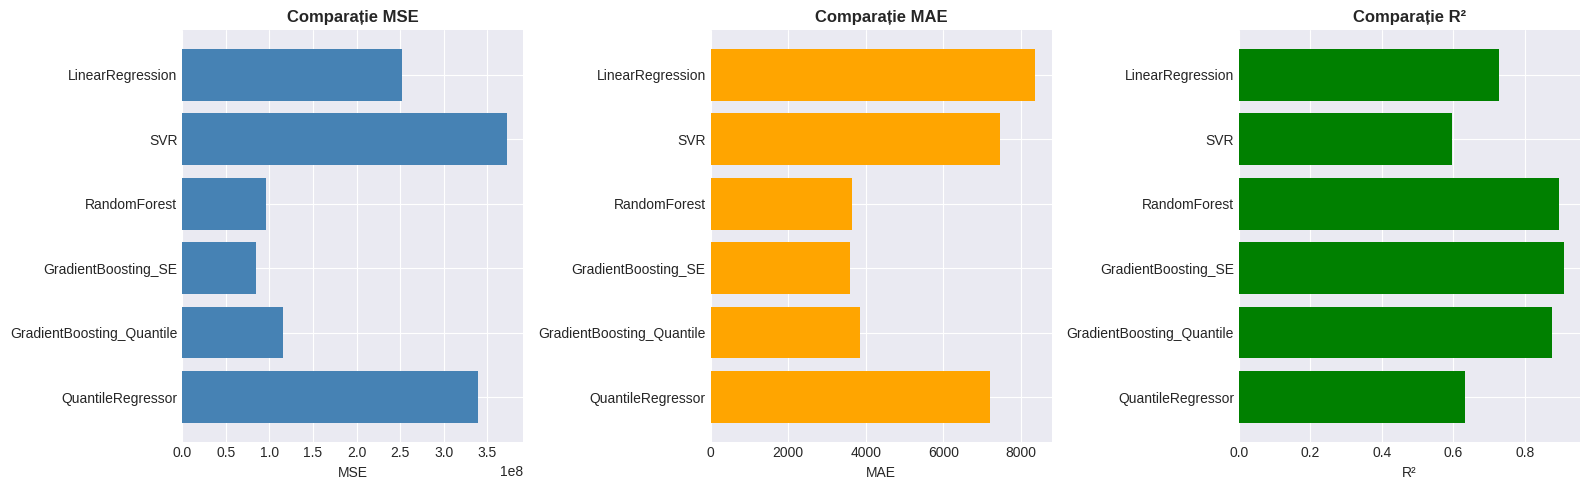

In [148]:

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].barh(results_df_auto.index, results_df_auto['MSE'], color='steelblue')
axes[0].set_xlabel('MSE')
axes[0].set_title('Comparație MSE', fontweight='bold')
axes[0].invert_yaxis()

axes[1].barh(results_df_auto.index, results_df_auto['MAE'], color='orange')
axes[1].set_xlabel('MAE')
axes[1].set_title('Comparație MAE', fontweight='bold')
axes[1].invert_yaxis()

axes[2].barh(results_df_auto.index, results_df_auto['R2'], color='green')
axes[2].set_xlabel('R²')
axes[2].set_title('Comparație R²', fontweight='bold')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()
# Save predictions
best_model_name = results_df_auto['R2'].idxmax()
models_map = {
    'LinearRegression': lr,
    'SVR': best_svr,
    'RandomForest': best_rf,
    'GradientBoosting_SE': best_gb,
    'GradientBoosting_Quantile': gb_q50,
    'QuantileRegressor': best_qr
}

best_model = models_map[best_model_name]
test_predictions = best_model.predict(X_test_final)

df_test_auto['predictii_pret'] = test_predictions
df_test_auto[['nume', 'predictii_pret']].to_csv('predictii_autovit_final.csv', index=False)

